# SOM - CESM Member 001

#### Template from 'Basic uses of SOMPY library', modified for our use
* http://www.vahidmoosavi.com
* https://github.com/sevamoo/sompy

#### Notebook Features
* Import packages required for SOM module SOMPY, and SOMPY itself (note this must be cloned from repo into local dir
* Load Data
* Clean & organize data into format/interval of interest
* Quick visualizations for context
* Basic SOM training with sample data
* Visualize SOM results
* Attempt on monthly clusters
* Extract cluster designations

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
# import sompy as sompy
import pandas as pd
import numpy as np
from time import time
import sompy

import os
import numpy as np
import xarray as xr

import datetime

from sklearn.preprocessing import StandardScaler

backend module://ipykernel.pylab.backend_inline version unknown


In [104]:
import math
import glob
from sklearn.externals import joblib
import random

from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import logging

In [6]:
#Windows
#DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'

#Mac
DATA_DIR = '/Users/cg/co2/'

#Define key names and import .nc data
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [7]:
#create dataframe for data prep

df = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


In [8]:
#choose features of interest from within raw model data, concatenate into data frame
SOM_input = pd.concat([df['SSS'],df['MLD']['MLD'],df['SST']['SST'],df['Chl']['Chl'],df['pCO2']['pCO2']], axis=1)

SOM_input.shape
#SOM_input.head()

### Note: Based on prior EDAV, 15k outliers from SSS removed, see scatterplots
* Could further constrain data to improve model parameters, but 'lost' data may have more information we don't want to omit

In [10]:
#Filter out outliers, SSS
SOM_input = SOM_input.loc[SOM_input['SSS'] > 8]

In [11]:
#legacy sample code for prototyping
test_sample = SOM_input.sample(10000)

#### Scatterplot & Scatter Matrix
* quick view of data relationships prior to model build

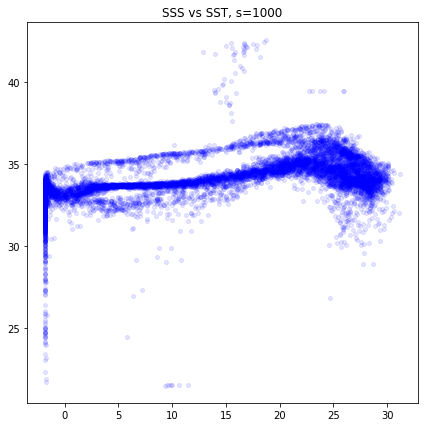

In [28]:
fig = plt.figure()
plt.plot(test_sample['SST'],sample['SSS'],'ob',alpha=0.1, markersize=4)
plt.title('SSS vs SST, s=1000')
fig.set_size_inches(7,7)

In [31]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2e2b4790>,
      dtype=object)

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans (u'/Users/cg/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


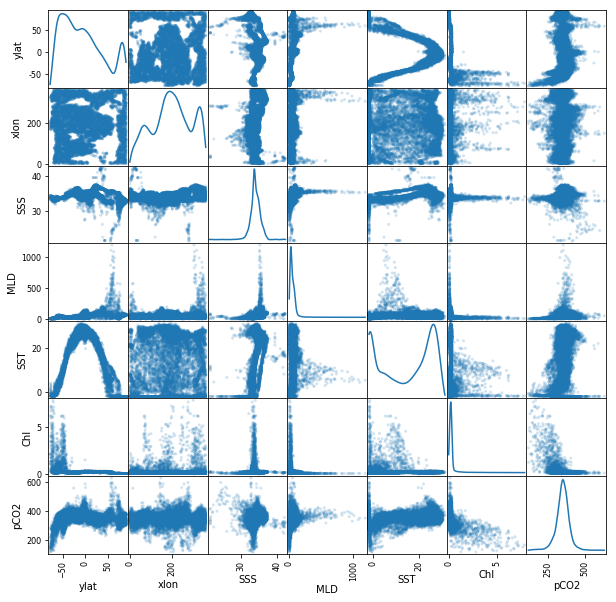

In [34]:
scatter_matrix(sample, alpha=0.2, figsize=(10,10), grid=False, diagonal='kde')

#### Notes
* See miniature map ylat v xlon
* Interesting SST v ylat
* Chl... looks like high  Chl content in antarctic, and not much use spatially otherwise (see Chl v xlon)
* MLD v ylat, can see 'zone' of higher MLD, same with xlon. Is this Atlantic Ocean? 

# Scale Data

#### choice of normalization or transform? 
* would like to try sample runs both ways and evaluate performance 

In [14]:
#sample_scatter[['SSS','SST']] = StandardScaler().fit_transform(sample_scatter[['SSS','SST']])
ss = StandardScaler().fit_transform(test_sample[['SSS','SST','MLD','pCO2']])

/Users/cg/anaconda3/envs/sompy_env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cg/anaconda3/envs/sompy_env/lib/python2.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [15]:
ss.shape

(10000, 4)

In [ ]:
#### Initialize neural map size based on empirical heuristics

In [16]:
M = 5*np.sqrt(ss.shape[0])

In [18]:
m = int(np.sqrt(M))
m

22

In [19]:
#Train SOM
#this will use the default parameters besides map size, but can change as needed
mapsize = [m,m]
som = sompy.SOMFactory.build(ss, 
                             mapsize, 
                             mask=None, 
                             mapshape='planar', 
                             lattice='rect', 
                             normalization='var', 
                             initialization='pca', 
                             neighborhood='gaussian', 
                             training='batch', 
                             name='sompy')  

#manually set rough/fine number of epochs for training
#verbose='debug' will print more, and verbose=None wont print anything
som.train(n_job=1, verbose='info', train_rough_len = 25, train_finetune_len = 50)  


 Training...
 pca_linear_initialization took: 0.216000 seconds
 Rough training...
 radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 25

 epoch: 1 ---> elapsed time:  0.127000, quantization error: 0.968115

 epoch: 2 ---> elapsed time:  0.117000, quantization error: 0.773291

 epoch: 3 ---> elapsed time:  0.118000, quantization error: 0.658556

 epoch: 4 ---> elapsed time:  0.115000, quantization error: 0.605373

 epoch: 5 ---> elapsed time:  0.114000, quantization error: 0.585753

 epoch: 6 ---> elapsed time:  0.118000, quantization error: 0.574008

 epoch: 7 ---> elapsed time:  0.115000, quantization error: 0.563666

 epoch: 8 ---> elapsed time:  0.117000, quantization error: 0.554206

 epoch: 9 ---> elapsed time:  0.116000, quantization error: 0.544601

 epoch: 10 ---> elapsed time:  0.221000, quantization error: 0.534740

 epoch: 11 ---> elapsed time:  0.120000, quantization error: 0.525034

 epoch: 12 ---> elapsed time:  0.217000, quantization error: 0.514999

 epoch: 13 --

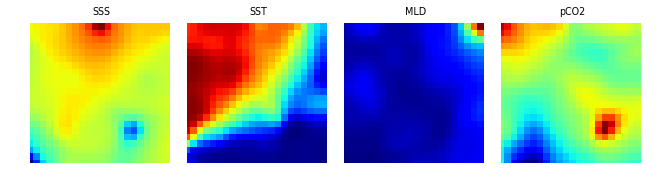

In [20]:
som.component_names = ['SSS','SST','MLD','pCO2']
v = sompy.mapview.View2DPacked(40, 40, '',text_size=8)  
v.show(som, what='codebook', cmap='jet', col_sz=6) #which_dim='all' default


In [23]:
# c = sompy.mapview.View2DPacked()
v = sompy.mapview.View2DPacked(5, 2, 'test',text_size=8)  

#first you can do clustering. Currently only K-means on top of the trained som
#note ability to change number of defined clusters on demand
cl = som.cluster(n_clusters=5)
# print cl
getattr(som, 'cluster_labels')

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2,

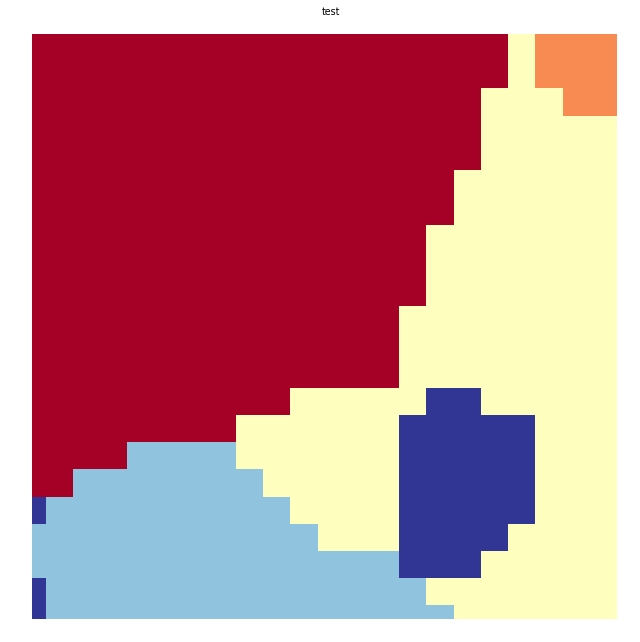

In [24]:
v.show(som, what='cluster')

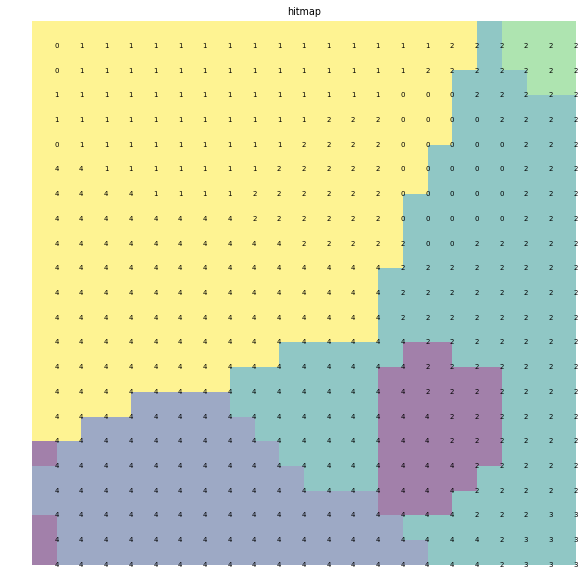

In [25]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

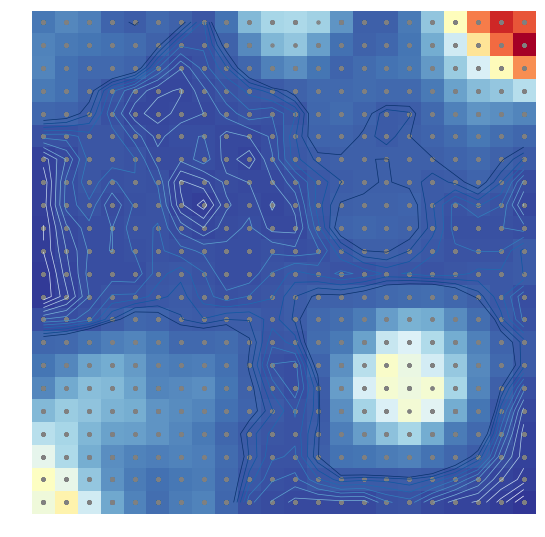

In [26]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(som, distance=1, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(som, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)


# TO DO
* Interpret hitmap and u-matrix more.. pretty but what can be learned?
* Try with other combos, e.g., No Chl or log(MLD) per Landschutzer
* Perform tuning exercise to choose model with lowest error
* Validate conversion of SOM results back to cluster designation for raw data (e.g., translation of neuron results to all raw data points based on centroid/BMU value)
* Validate that "clustering" method described using k-means above, post model-build, is what we're looking for

# Create month specific dataframes

In [12]:
#convert time info into date-time format
SOM_input.set_index(pd.DatetimeIndex(SOM_input['time']))

#create month column
SOM_input['month'] = pd.DatetimeIndex(SOM_input['time']).month

#create year column
SOM_input['year'] = pd.DatetimeIndex(SOM_input['time']).year

In [17]:
January = SOM_input.loc[SOM_input['month'] == 1]
January.shape

(1477260, 9)

In [ ]:
#usually a good idea to reset your index once you've extracted selected rows from greater dataset
January.reset_index(drop=True)

In [18]:
January = January.drop(columns=['time','month'])

In [86]:
January_v2 = January.drop(columns=['Chl'])

In [92]:
#log(MLD)
January_v2[['MLD']] = January[['MLD']].apply(np.log)

In [93]:
January_v2.head()

,ylat,xlon,SSS,MLD,SST,pCO2
0,-77.5,179.5,34.000992,2.784570,1.648732,151.525853
1,-77.5,180.5,33.941429,2.715717,1.528921,150.330599
2,-77.5,181.5,33.863464,2.644176,1.350243,148.500409
3,-77.5,182.5,33.775764,2.570496,1.119088,146.198458
4,-77.5,183.5,33.691376,2.512309,0.865820,143.769723


In [100]:
ss2 = StandardScaler().fit_transform(January_v2[names])

In [101]:
import random

In [ ]:
# Train the model with different parameters. The more, the better. Each iteration is stored in disk for further study 
for i in range(5): 
    sm = sompy.SOMFactory().build(ss2, 
                            mapsize=[random.choice(list(range(15, 25))), 
                                     random.choice(list(range(10, 15)))], 
                            normalization = 'var', initialization='random', 
                            component_names=names, lattice="rect") 
    sm.train(n_job=4, 
             verbose=False, 
             train_rough_len=30, 
             train_finetune_len=100) 
    
    joblib.dump(sm, "model_{}.joblib".format(i))

In [ ]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool = glob.glob("./model*")
errors=[]
for model_filepath in models_pool:
    sm = joblib.load(model_filepath)
    topographic_error = sm.calculate_topographic_error()
    quantization_error = sm.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top, e_q = zip(*errors)

In [ ]:
plt.scatter(e_top, e_q)
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()